In [1]:
from interpolML.model.orbit import Orbit
from interpolML.model.neural_prophet import NProphet
from orbit.utils.dataset import load_iclaims
from interpolML.diagnostics.plotter import Plotter
from interpolML.interpolation.interpolation import Interpolation
from pandas_datareader.data import DataReader
from datetime import datetime
import pandas as pd
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from interpolML.diagnostics.metrics import Metrics
import mylib

ModuleNotFoundError: No module named 'mylib'

## Summary

Missing values is a problem that occurs in the data observation process, it could happen for several reasons including measurement failures, formatting problems, human errors or lack of information on the database, so if you want to forecast product demand or your company stock market value missing values can significantly impact a model's accuracy. In this paper, we will explain new interpolation that weren't worked at class to manage missing values through interpolation and how this approach affect time series data prediction, using Uber Orbit and Facebook Neural Prophet forecasting libraries. The discussion's aim is to experiment using simple techniques discussed in class to handle missing values, and use this data to make a more accurate predictions.

In [2]:
df = load_iclaims()
df = df.rename(columns={"week" : "ds", "claims" : "y"})
df = df[["ds", "y"]]
test_size = 100

In [3]:
interpolation = Interpolation(df,0.3, method="newton")

In [4]:
missing = deepcopy(interpolation.missing)
df = deepcopy(interpolation.data)
interpolated = deepcopy(interpolation.interpolated)

df["y"] = pd.to_numeric(df["y"])
interpolated["y"] = interpolated["y"].astype(float)

## Data

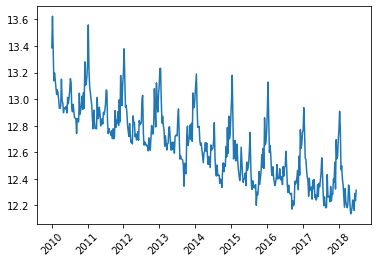

In [5]:
from matplotlib import pyplot as plt

plt.plot(df['ds'], df['y'], '-')
_ = plt.xticks(rotation=45)

## Deleted data

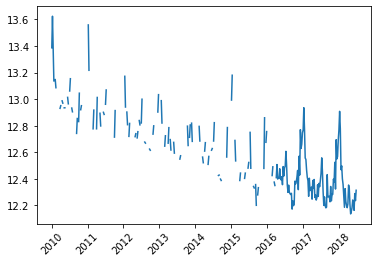

In [6]:
from matplotlib import pyplot as plt

plt.plot(missing['ds'], missing['y'], '-')
_ = plt.xticks(rotation=45)

In [7]:
import numpy as np
last_value_missing = max(missing[np.isnan((missing["y"]))].index)

test_size = len(df) - last_value_missing
train_df = interpolated[:-test_size]
test_df = interpolated[-test_size:]

## Interpolated data

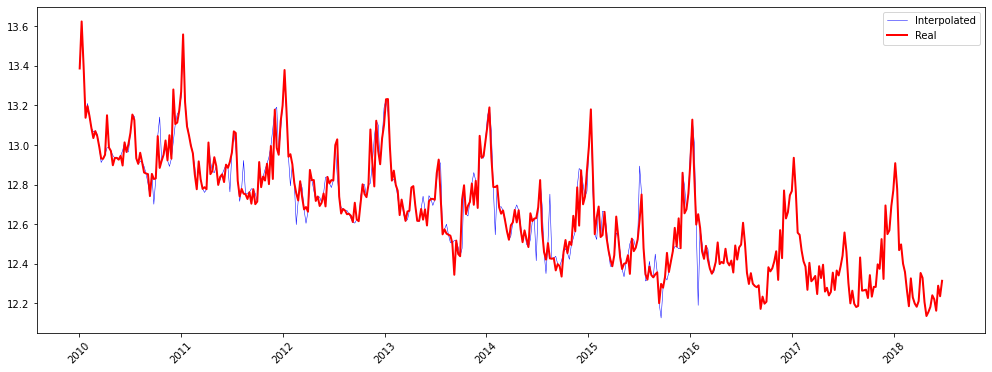

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(17,6))
plt.plot(interpolated['ds'], interpolated['y'], 'b-', markersize=1, linewidth=0.5, label="Interpolated")
plt.plot(df['ds'], df['y'], 'r-', label="Real", markersize=1, linewidth=2)
plt.legend(loc="best")
_ = plt.xticks(rotation=45)


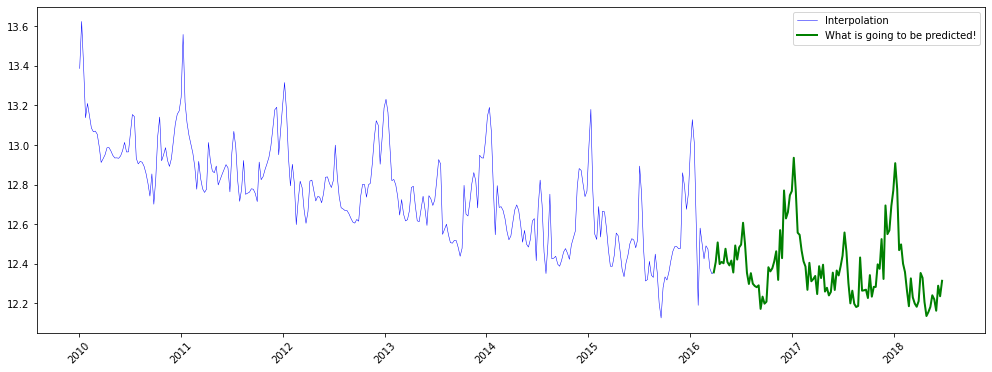

In [9]:
plt.figure(figsize=(17,6))
plt.plot(interpolated['ds'], interpolated['y'], 'b-', markersize=1, linewidth=0.5, label="Interpolation")
plt.plot(test_df['ds'], test_df['y'], 'g-', label="What is going to be predicted!", markersize=1, linewidth=2)
plt.legend(loc="best")
_ = plt.xticks(rotation=45)

In recent years, machine learning, deep learning, and probabilistic programming have shown great promise in generating accurate forecasts. In addition to standard statistical algorithms, Uber builds forecasting solutions using these three techniques. Below, we discuss the critical components of forecasting we use, popular methodologies, backtesting, and prediction intervals.

A critical element of our platform, marketplace forecasting enables us to predict user supply and demand in a spatio-temporal fine granular fashion to direct driver-partners to high demand areas before they arise, thereby increasing their trip count and earnings. Spatio-temporal forecasts are still an open research area.

\-Uber

In [10]:
from IPython.display import HTML
HTML('<img src="../img/marketplace_forecasting.gif">')

In recent years, machine learning approaches, including quantile regression forests (QRF), the cousins of the well-known random forest, have become part of the forecaster’s toolkit. Recurrent neural networks (RNNs) have also been shown to be very useful if sufficient data, especially exogenous regressors, are available. 
https://eng.uber.com/forecasting-introduction/

# Orbit Model

In [11]:
from IPython.display import HTML
HTML('<img src="../img/flux_orbit.png">')

In [12]:
from IPython.display import HTML
HTML('<img src="../img/lgt.png">')

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


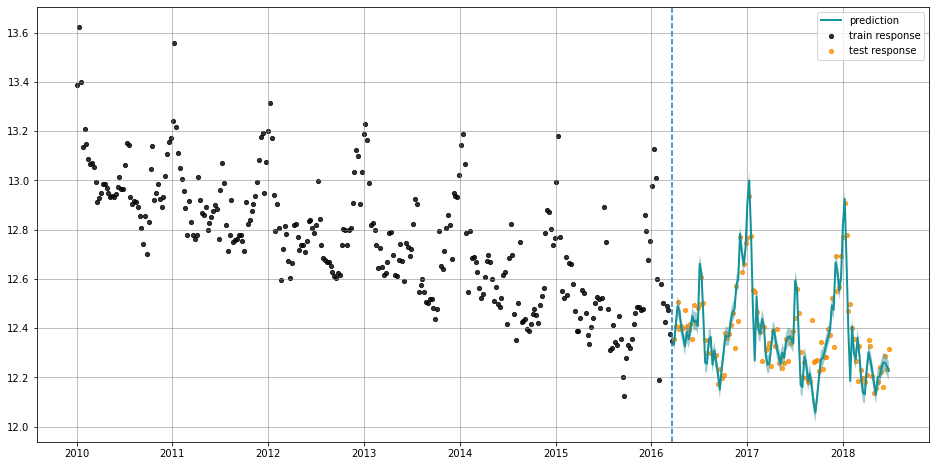

In [13]:
orbit = Orbit(freq="W")
orbit.fit(train_df)
predicted_df = orbit.predict(test_df)
Plotter(orbit).plot_predicted_data()

# Neural Prophet

A new framework that combines the best of both traditional statistical models and neural network models for time series modeling, which is prevalent in many important applications, such as forecasting and anomaly detection. Classical models such as autoregression (AR) exploit the inherent characteristics of a time series, leading to a more concise model. This is possible because the model makes strong assumptions about the data, such as the true order of the AR process. These models, however, do not scale well for a large volume of training data, particularly if there are long-range dependencies or complex interactions.

\-Facebook

Consider a time series y1 , ... , yt, expressed as an AR process. In order to predict the next time step yt, each of the p past values of y is multiplied by a learned weight wi (called AR coefficient).

In [14]:
from IPython.display import HTML
HTML('<img src="../img/equation_prop.png">')

In [15]:
from IPython.display import HTML
HTML('<img src="../img/layers_prop.jpg">')

For a large p (called order), the traditional approach can become impractically slow to train. However, a large order is required for monitoring high-resolution millisecond or second-level data. To overcome the scalability challenge, we train a neural network with stochastic gradient descent to learn the AR coefficients. If we know the true order of the process, AR-Net effectively learns near-identical weights as classic AR implementations and is equally good at predicting the next value of the time series.

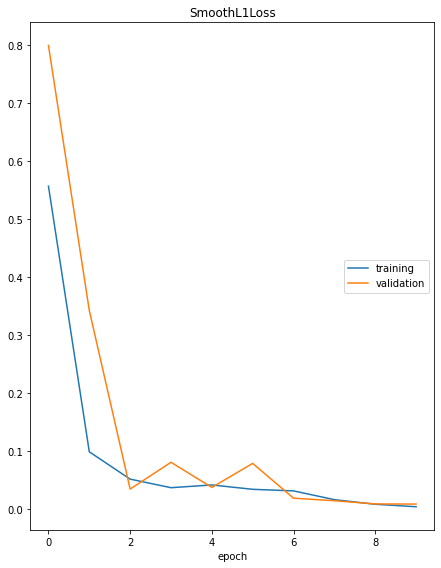

Epoch[10/10]: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s, SmoothL1Loss=0.00452, MAE=0.0722, RegLoss=0, MAE_val=0.104, SmoothL1Loss_val=0.00912]


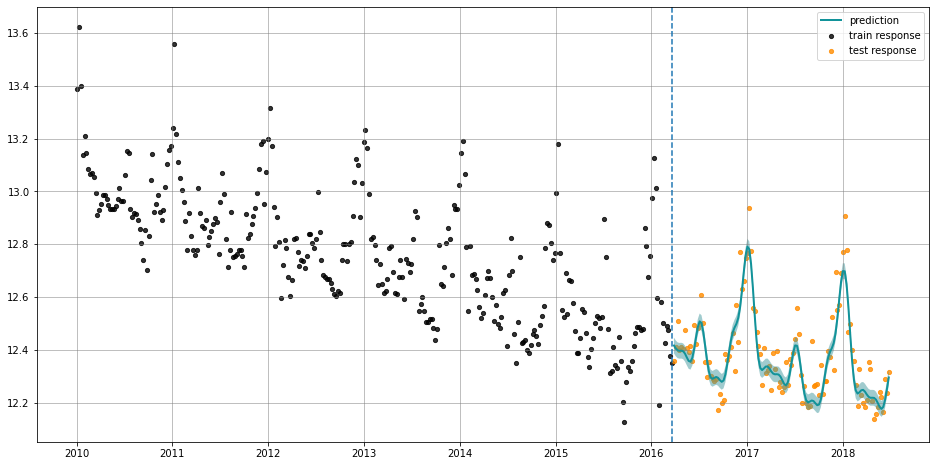

In [16]:
neural_prophet = NProphet(freq="W")
neural_prophet.fit(train_dataset=train_df)
predicted_df  = neural_prophet.predict(test_df)
Plotter(neural_prophet).plot_predicted_data()

# Metrics

### Orbit

In [19]:
metrics1 = Metrics(orbit, df).score()
metrics2 = Metrics(neural_prophet, df).score()
metrics1["model"] = "orbit"
metrics2["model"] = "nprophet"
metrics = metrics1.append(metrics2)

<AxesSubplot:xlabel='metric_name', ylabel='metric_values'>

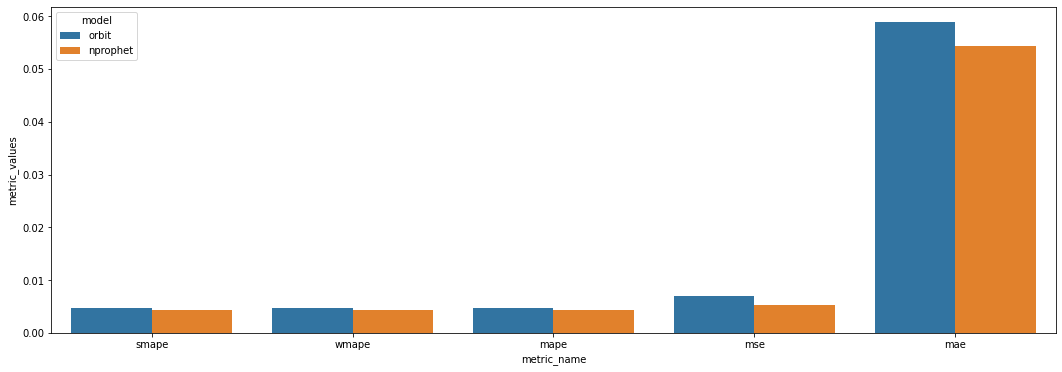

In [25]:
ax = plt.subplots(figsize=(18,6))
sns.barplot(x="metric_name", y="metric_values", hue="model", data=metrics)

### Neural Prophet

# Referencias

https://towardsdatascience.com/how-to-use-facebooks-neuralprophet-and-why-it-s-so-powerful-136652d2da8b
https://eng.uber.com/orbit/
https://eng.uber.com/forecasting-introduction/
https://cran.r-project.org/web/packages/Rlgt/vignettes/GT_models.html
https://ai.facebook.com/blog/ar-net-a-simple-autoregressive-neural-network-for-time-series/